# Notebook used for the making of the single atom SET (first attempt).
#### It includes scan stitching, dopant finding, etc

In [1]:
import sys
from pathlib import Path
# Add the parent directory to sys.path so we can import NVM and ASD from parent directory
sys.path.append(str(Path().resolve().parent.parent))
import NavigatingTheMatrix as nvm
import As_detection as asd

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import os
import cv2
import importlib 
import re

C:\Users\nkolev\OneDrive - University College London\Documents\GitHub\NavigatingTheMatrix\As_detection.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

Currently, the scan stitching requires some spatial information to be given. It requires the relative position of the scans to each other i.e. we assume a 2D array of scans of shape n x n. Then the scans need a label (i, j) to indicate where in the array they are.
I'm unsure of the most efficient/easiest way to implement this. If scanning is done automatically and each following scan has a definite and known relationship with the previous, it's relatively easy to get this (i, j) labelling. This likely won't be the case most of the time though. ATM I think the easiest will be if the desired scans are moved into a separate folder and just this folder is processed so it's easy enough to ignore the scans inbetween where tip cleaning etc is performed.

In [2]:
# make a dictionary of the scans you want to stitch

scans = {}

dir_path = Path().resolve()

# get list of all scan numbers from the filenames in the directory
scan_numbers = []
for filename in os.listdir(dir_path):
    if filename[-6:] == 'Z_mtrx':
        match = re.search(r'--(\d+)_', filename)
        if match:
            scan_number = int(match.group(1))
            scan_numbers.append(scan_number)

# scans are arranged in a raster pattern. Smallest scan number is bottom left, from there it goes right 3, then up 1, left 3, up 1, etc.
# NOTE: scan numbers do not go up in ones.


scan_numbers.sort()
print('Scan numbers found:', scan_numbers)

n = 0 # counter to keep track of the scan number in the raster pattern
for scan_number in scan_numbers:
    for filename in os.listdir(dir_path):
        if filename[-6:] == 'Z_mtrx':
            match = re.search(r'--(\d+)_', filename)
            if match:
                number = int(match.group(1))
            if scan_number == number:
                n1 = n//3
                n2 = n%3
                scan_dict = {'file': os.path.join(dir_path, filename), 
                            'standard_pix_ratio': 512/100
                            }
                scans[(n1,n2)] = nvm.STM(scan_dict)
                n += 1 
                

Scan numbers found: [15]
standard pix ratio:  5.12
Pixel to nm ratio in y direction is 46pixels for every 100nm in the  trace down
trace down scan was interupted before completion. It will not be used.
Pixel to nm ratio in y direction is 46pixels for every 100nm in the  retrace down
retrace down scan was interupted before completion. It will not be used.


In [3]:
# tidy up the scans. 

for scan in scans.values():
    scan.clean_up(scan.trace_up, 'trace up', plane_level=True)
    scan.clean_up(scan.retrace_up, 'retrace up', plane_level=True)

In [4]:
# correct hysterisis in the scans

for scan in scans.values():
    scan.trace_up_proc, scan.retrace_up_proc, corrected, k3_1 = scan.correct_hysteresis(scan.trace_up_proc, scan.retrace_up_proc, 'trace up')

Number of matches found for hysteresis correction: 24 . If it's only a few (less than ~3) the correction will not be very accurate.


- how does using the crops from different images affect this? When i separate them by image into train, val, test, accuracy is very different.
- need a consistent normalisation since some images have spikes in them. 

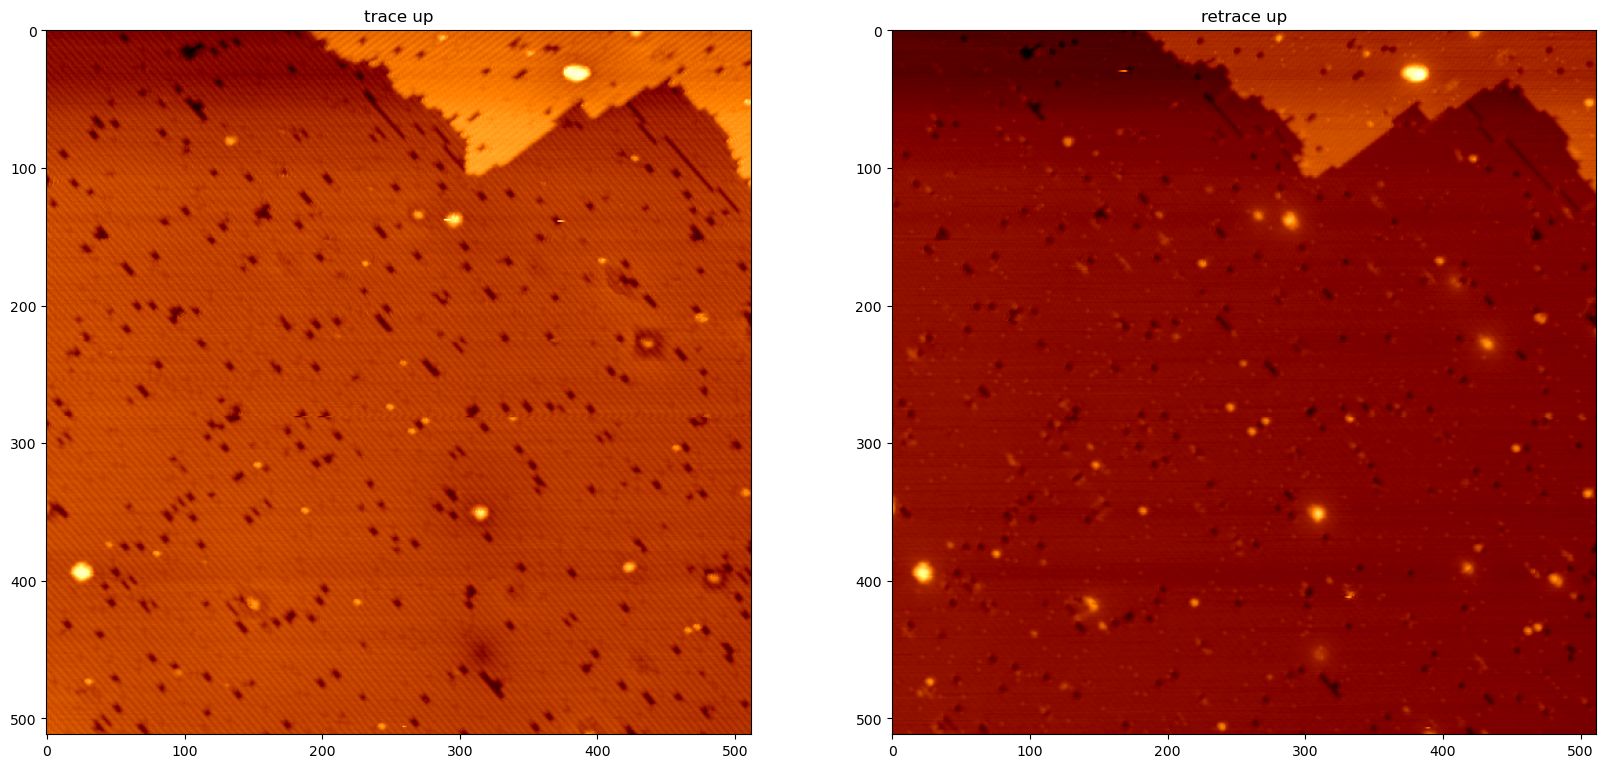

In [5]:
# plot a few to check they are as expetected.
# Note that many of the scans uses in this example are of bad quality.

for i, key in enumerate(scans.keys()):
    if i<6: # plot the first 6 scans
        fig, ax = plt.subplots(1,2, figsize=(20,15))
        ax[0].imshow(scans[key].trace_up_proc, cmap='afmhot')
        ax[0].set_title('trace up')
        ax[1].imshow(scans[key].retrace_up_proc, cmap='afmhot')
        ax[1].set_title('retrace up')
        plt.show()

In [19]:
importlib.reload(asd)

<module 'As_detection' from 'C:\\Users\\nkolev\\OneDrive - University College London\\Documents\\GitHub\\NavigatingTheMatrix\\As_detection.py'>

In [20]:
detector = asd.Detector()

In [21]:
# make a dict of the scans to use
segmented_scans = {}

for key, scan in scans.items():
    print(key)
    segmented_scans[key] = asd.Si_Scan(scan, 'trace up', As=True)
    segmented_scans[key].one_hot_segmented = detector.predict(segmented_scans[key], remove_noise=False)
    segmented_scans[key].rgb = detector.turn_rgb(segmented_scans[key].one_hot_segmented)

(0, 0)
Resolution of image is 512 by 512
Number of features is 43


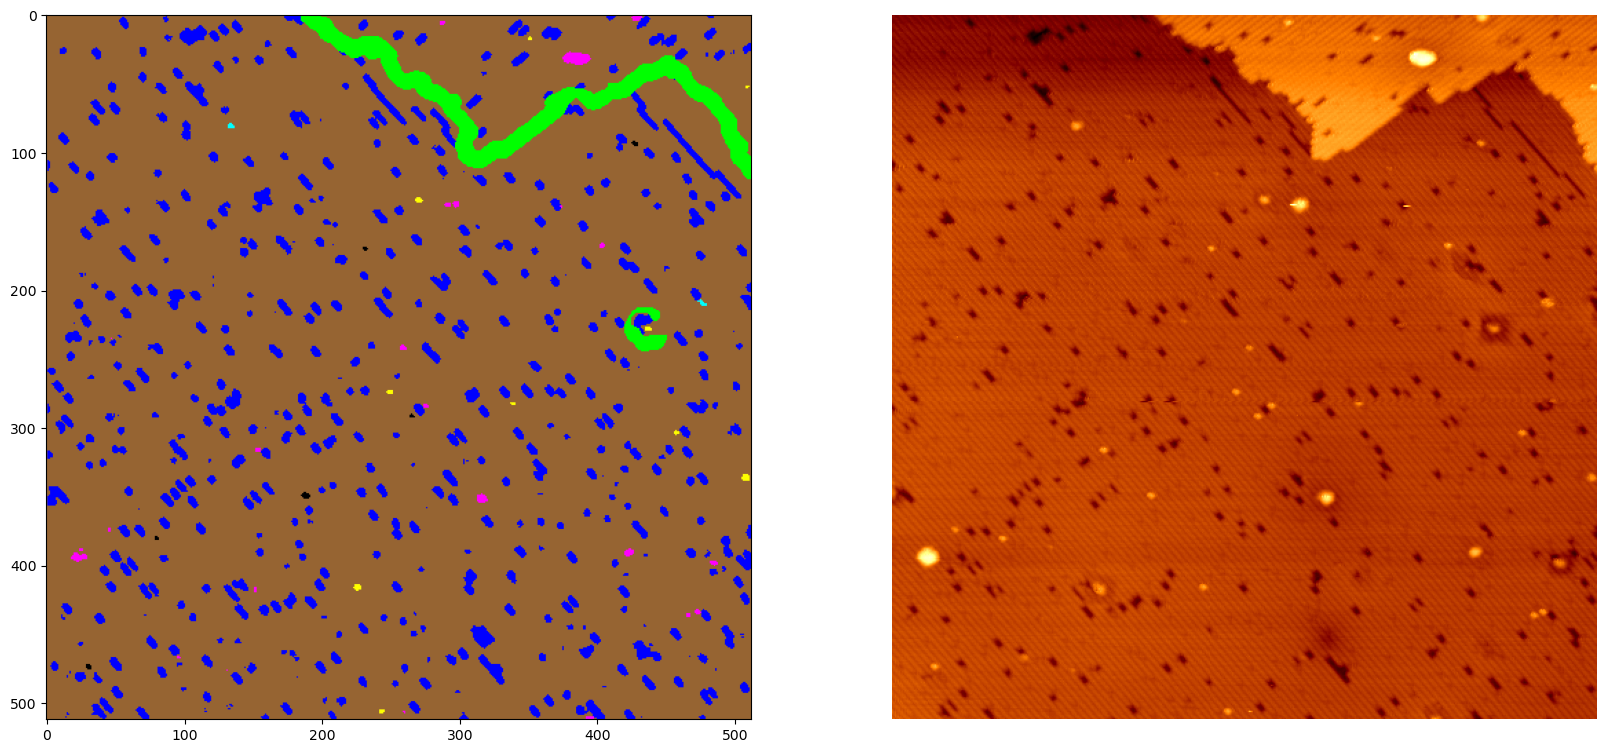

In [22]:
for i, (key,scan) in enumerate(scans.items()):
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    ax[1].imshow(scans[key].trace_up_proc, cmap='afmhot')
    ax[0].imshow(segmented_scans[key].rgb)
    plt.axis('off')
    plt.show()

### Find the homographies between all neihgbours. We do one with a size_change_thresh of 0.001 and one with 0.05.
### No stitching needed here, but kept it to illistrate the point and how to do it.

In [10]:
ScanStitcher = asd.segmented_scan_stitcher()

In [11]:
# get the homographies between neighbours where possible
homographies, graph, homographies_type, keypoints = ScanStitcher.get_all_homographies(segmented_scans, round_to = 10, counts1=4, counts2=10,show_plot=True, size_change_thresh=0.0001)

# graph is a dictionary which outlines the valid connections found between the scans.

Currently working on:  (1, 0) (0, 0)
Currently working on:  (0, 1) (0, 0)


#### You should look through the plots and check the homographies look roughly correct. There are automatic checks to get rid of bad homographies but it is not 100% correct still. There may be an error and you may need to delete some of them. It's usually only one or two, will be less if all scans are good quality.

In [12]:
# The bad homographies we found were. Note that the algorithm used to find the homographies is probabilistic
# so the results may vary between runs.

# Note, ee need to get rid of the homographies in both directions (i.e. going from scan (1,2) to (1,1) and from (1,1) to (1,2))

# to get rid of the bad homographies, we can use the pop method on the dictionary.
# e.g. to get rid of the homography from (3,3) to (2,3) we can do:
# homographies.pop(((3,3),(2,3)))
# homographies.pop(((2,3),(3,3)))


### We'd like to illustrate the which homographies were found between which neighbours in a nice diagram.

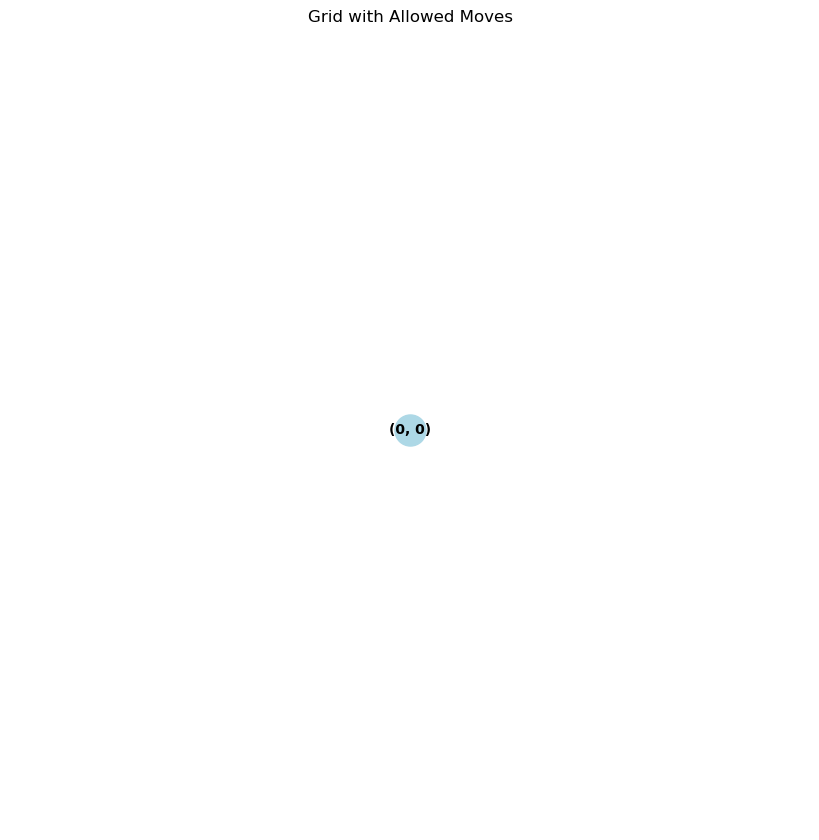

In [13]:
# illustrate which homographies were found. Just provide the graph, the homography types, and the grid size.
# green = full homography
# yellow = translation only (full homography changes the size too much)

ScanStitcher.plot_grid_with_moves((1,1), graph, homographies_type) # 0.1% size change tolerance 


In [14]:
# this function stitches the scans by using homographies that were calculated by 
# comparing one scan with its neighbours
stitched_scan = ScanStitcher.stitch_from_homographies(segmented_scans, homographies, graph, stitch_for_n=6)

In [15]:
def turn_rgb(self, array, scan = False):
    '''
    Turns one-hot encoded array with up to 7 categories into an rgb image

    Args:
        array (ndarray): shape (res,res,7) with the different features labelled with
                one-hot encoding.
    returns:
        output (ndarray): Shape (res,res,3) with the different features labelled with
                rgb encoding.
        legend (dict): The rgb values as keys and the corresponding feature as values
        scan (False or ndarray): If not false, the scan is used to make the output have zeros where the scan is zero
    '''
    # Define the mapping from categories to RGB colors
    category_to_rgb = (255*np.array(list(self.legend.keys()))).astype(np.uint8)

    # Get the category indices from the one-hot encoded array
    category_indices = np.argmax(array, axis=-1)

    # Map the category indices to RGB colors
    output = category_to_rgb[category_indices]

    if np.any(scan) != False:
        # if given the true scan, we want to have zeros in the same places.
        output[scan[:,:,0]==0] = [0,0,0]

    return output

In [16]:
# object returned is a Si_scan object and all defects are transformed to the new coordinates sytem 
# + we get a new one hot segmented maps but we don't have a rgb image of the new scan
stitched_scan.rgb = turn_rgb(detector, stitched_scan.one_hot_segmented, stitched_scan.scan)

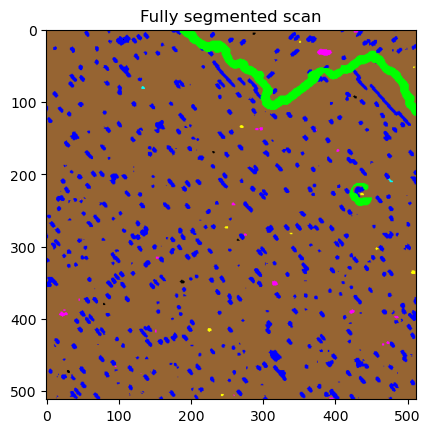

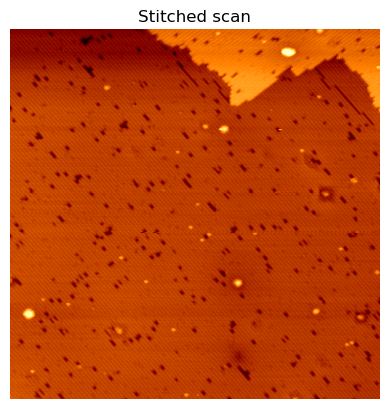

In [17]:
axis_ticks = np.linspace(0, stitched_scan.scan.shape[1], 2)
axis_labels = axis_ticks/512*1000
plt.imshow(stitched_scan.rgb)
#plt.xticks(axis_ticks, axis_labels)
plt.title('Fully segmented scan')
plt.show()

plt.imshow(stitched_scan.scan[:,:,0], cmap='afmhot')
plt.title('Stitched scan')
plt.axis('off')
plt.show()

### Now we can also find pairs and triplet in this scan.

In [40]:
# first find distances between all features

stitched_scan.feature_dists()

In [41]:
stitched_scan.scan.shape[0]*200/1024

100.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


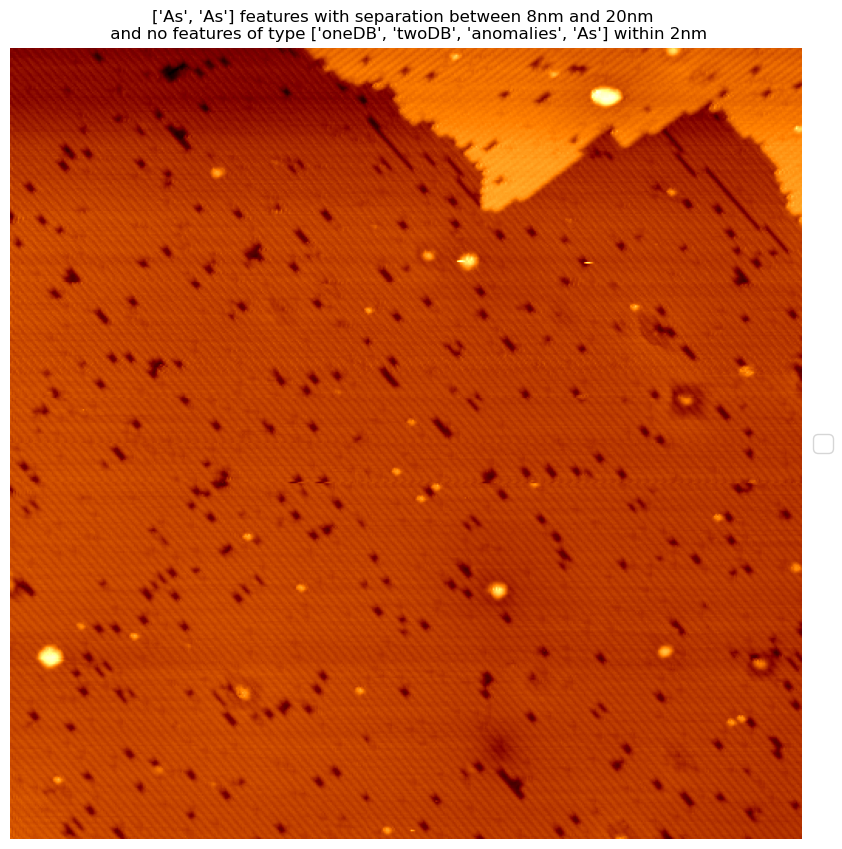

In [42]:
# find 'oneDB' pairs at a distance of between 10 nm and 8 nm, that also have no other 'oneDB' defects within 10 nm.

As_pairs = stitched_scan.find_pairs('As', 'As', max_dist=20, min_dist=8,
                                        exclusion_dist = 2, display_image=True)

## Let's go for number 3 since the pair is nearly on the same dimer row and we can use the dimers to calculate the distance between source, drain, and dopant.

In [ ]:
# find triplets of 'As' defects at a distance of between 10 nm and 8 nm. The triplet make a triangle, the 
# max angle of the triangle is 150 degrees and the minimum angle is 30 degrees.
# They also have no other 'oneDB' defects within 10 nm.


oneDB_triplets = stitched_scan.find_triplets('As', 'As', 'As', max_dist=12, min_dist=8, max_angle = 150, min_angle = 30,
                                        exclusion_dist = 5, display_image=True)